# Handling WOD netCDF files

The purpose of this notebook is to demonstrate the functionality of `WODbottom`.

The demo is organised to show

- Step 1: Explanation

- Step 2: Explanation

Note that when you submit a pull request, you should `clear all outputs` from your python notebook for a cleaner merge.


In [9]:
import pathlib
import sys

script_dir = pathlib.Path().parent.absolute()
parent_dir = script_dir.parents[0]
sys.path.append(str(parent_dir))
print(parent_dir)

import xarray as xr
import os
from WODbottom import readers, writers, plotters, tools, utilities
import pandas as pd


/Users/eddifying/Cloudfree/gitlab-cloudfree/WODbottom


In [10]:
# Specify the path for writing datafiles
data_path = os.path.join(parent_dir, 'data')

In [11]:
input_dir = '/Users/eddifying/Dropbox/Data/WB_Atlantic_WOD_CTD/'

file_count = len([name for name in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, name))])
print(f'There are {file_count} files in the input directory.')

There are 221130 files in the input directory.


# Load one file

In [ ]:
# Find the first file in the input_dir that starts with 'wod'
first_file = next((f for f in os.listdir(input_dir) if f.startswith('wod')), None)

if first_file:
    file_path = os.path.join(input_dir, first_file)
    ds = xr.open_dataset(file_path)
    ds
else:
    print("No file starting with 'wod' found in the input directory.")


In [13]:
ds

<xarray.Dataset> Size: 1kB
Dimensions:                     (z: 9)
Coordinates:
    lat                         float32 4B ...
    lon                         float32 4B ...
    time                        datetime64[ns] 8B ...
  * z                           (z) float32 36B 6.59 9.16 14.38 ... 39.52 42.87
Data variables: (12/25)
    country                     |S200 200B ...
    WOD_cruise_identifier       |S200 200B ...
    wod_unique_cast             int32 4B ...
    date                        int32 4B ...
    GMT_time                    float32 4B ...
    Access_no                   int32 4B ...
    ...                          ...
    Salinity_WODprofileflag     int16 2B ...
    Salinity_Instrument         |S200 200B ...
    crs                         int32 4B ...
    WODf                        int16 2B ...
    WODfp                       int16 2B ...
    WODfd                       int16 2B ...
Attributes: (12/37)
    flag_definitions:              WODfd
    institution:                   National Oceanographic Data Center(NODC), ...
    source:                        World Ocean Database
    references:                    World Ocean Database 2013. URL:http://data...
    title:                         World Ocean Database - Unique Cast 003377720
    summary:                       Data for single cast from the World Ocean ...
    ...                            ...
    history:                       
    license:                       
    standard_name_vocabulary:      CF-1.6
    featureType:                   Profile
    cdm_data_type:                 Profile
    Conventions:                   CF-1.6

In [ ]:
def process_file(file_name, input_dir):
        if file_name.startswith('wod') and file_name.endswith('.nc'):
            file_path = os.path.join(input_dir, file_name)
            ds = xr.open_dataset(file_path, decode_timedelta=True)

            if 'Salinity' in ds and 'Temperature' in ds:
                lat = ds.lat.item()
                lon = ds.lon.item()
                max_z = ds.z.max().item()
                #                max_z_index = ds.z.where(ds.z == max_z, drop=True).squeeze().item()
                temp_at_max_z = ds.Temperature.where(ds.z == max_z, drop=True).squeeze().item()

                #                temp_at_max_z = ds.Temperature.sel(z=max_z, method='nearest').item()
                salinity_at_max_z = ds.Salinity.where(ds.z == max_z, drop=True).squeeze().item()
                #                salinity_at_max_z = ds.Salinity.sel(z=max_z, method='nearest').item()
                if salinity_at_max_z < 0:
                    salinity_at_max_z = float('nan')
                if 'Bottom_Depth' in ds:
                    bottom_depth = ds.Bottom_Depth.item()
                else:
                    bottom_depth = None
                date = ds.date.item()
                wod_unique_cast = ds.wod_unique_cast.item()

                return {
                    'file_name': file_name,
                    'max_z': max_z,
                    'Temperature_at_max_z': temp_at_max_z,
                    'Salinity_at_max_z': salinity_at_max_z,
                    'Bottom_Depth': bottom_depth,
                    'date': date,
                    'Wod_unique_cast': wod_unique_cast,
                    'lat': lat,
                    'lon': lon
                }
            else:
                return None
        return None

results = []

for file_name in os.listdir(input_dir):
    if file_name.startswith('wod'):
        result = process_file(file_name, input_dir)
        if result:
            results.append(result)
        if len(results) % 10000 == 0:
            print(f'Processed {len(results)} files...')
            # Save results_df to a pickle file
            # Convert results to a DataFrame for better visualization
            results_df = pd.DataFrame(results)
            print(results_df)
            last_wod_unique_cast = results_df['Wod_unique_cast'].iloc[-1]
            results_df.to_pickle(os.path.join(data_path, f'results_df_{last_wod_unique_cast}.pkl'))
            results = []



# Convert the DataFrame to an xarray Dataset
results_ds = results_df.set_index(['date']).to_xarray()

# Rename the dimension to 'wod_profile'
results_ds = results_ds.rename_dims({'date': 'wod_profile'})

# Add lat and lon as coordinates
results_ds = results_ds.set_coords(['lat', 'lon'])
# Display the xarray Dataset
results_ds
# Save results_ds to a NetCDF file
results_ds.to_netcdf(os.path.join(data_path, 'results_ds.nc'))

Processed 10000 files...
              file_name        max_z  Temperature_at_max_z  Salinity_at_max_z  \
0     wod_003377720O.nc    42.869999                12.236          32.747002   
1     wod_003349816O.nc    48.650002                 3.470          32.041000   
2     wod_011121903O.nc    13.893403                12.671          31.768000   
3     wod_003331775O.nc  2157.290039                 3.519          35.681000   
4     wod_013339999O.nc   451.100006                17.500                NaN   
...                 ...          ...                   ...                ...   
9995  wod_005833749O.nc    92.250046                 5.180          33.026001   
9996  wod_015862608O.nc  1055.000000                 3.960          34.889999   
9997  wod_010435275O.nc    25.799999                 1.680          31.778000   
9998  wod_011188158O.nc    74.000000                 1.960          33.410000   
9999  wod_010499821O.nc   280.109741                 0.920          33.848999   

  

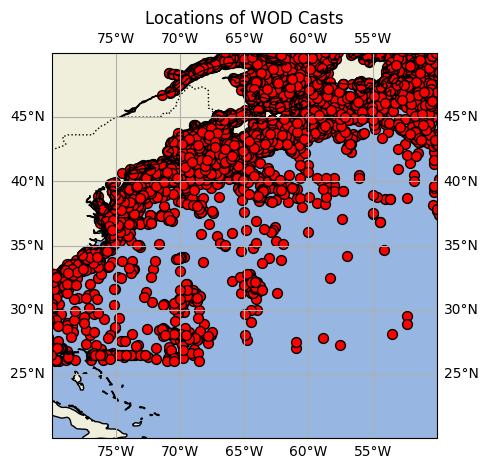

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Extract latitude and longitude from the results DataFrame
lats = results_df['lat']
lons = results_df['lon']

# Create a figure and axis with a specific projection
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Add features to the map
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the locations with circles
ax.scatter(lons, lats, color='red', s=50, edgecolor='k', transform=ccrs.PlateCarree())

# Set the extent of the map
ax.set_extent([-80, -50, 20, 50], crs=ccrs.PlateCarree())

# Add gridlines
ax.gridlines(draw_labels=True)

# Add a title
ax.set_title('Locations of WOD Casts')

# Show the plot
plt.show()

In [16]:
import numpy as np

# Define the range for latitude and longitude
lat_range = np.arange(25, 55, 0.1)
lon_range = np.arange(-90, -40, 0.1)

# Create a meshgrid
lon_grid, lat_grid = np.meshgrid(lon_range, lat_range)

print(f'Latitude grid shape: {lat_grid.shape}')
print(f'Longitude grid shape: {lon_grid.shape}')

# Find all results_ds.lat within 0.1 of lat_grid and results_ds.lon within 0.1 of lon_grid
lat_matches = np.abs(results_ds.lat.values[:, np.newaxis, np.newaxis] - lat_grid) <= 0.1
lon_matches = np.abs(results_ds.lon.values[:, np.newaxis, np.newaxis] - lon_grid) <= 0.1

# Combine the matches to find the points that satisfy both conditions
matches = lat_matches & lon_matches

print(f'Number of matches: {np.sum(matches)}')

Latitude grid shape: (300, 500)
Longitude grid shape: (300, 500)
Number of matches: 39976
